# Architecture of a Classification Neural Network
This model can built in almmost any shape or size. But typically, they have a same floor plan (input layer -> one or more hidden layers -> output layer).

Before writing code, this is the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass Classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g., 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10–512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g., 3 for food, person, or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit), but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) | [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (Stochastic Gradient Descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) — see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options | Same as binary classification |

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Create 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,        # noise to the dots
                    random_state=42)   # reproducibility

In [2]:
print(f"First 5 values of feature X:\n{X[:5]}")
print(f"\nFirst 5 values of label y:\n{y[:5]}")

First 5 values of feature X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 values of label y:
[1 1 1 1 0]


In [3]:
# There are 2 Xs for 1 y
# Create a dataframe using X and y (X[:0] for X1, X[:1] for X2, label for y)
# visualize, visualize, visualize
import pandas as pd

circles = pd.DataFrame({
    'X1': X[:,0],
    'X2': X[:,1],
    'label': y,
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# label are 0 and 1, this tells us that our case i binary classification (two options)
# Check label 
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

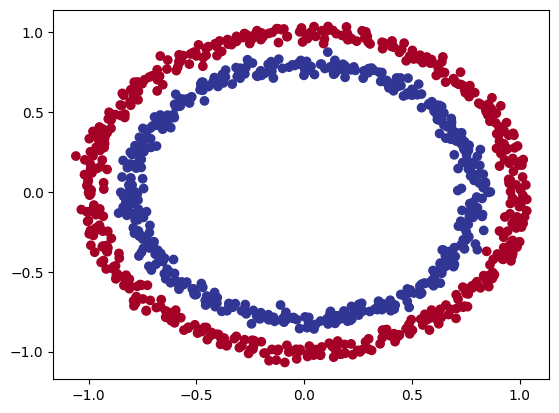

In [5]:
# balance like cash flow haha, 
# it is time to plot the data!
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and Output shapes

In [6]:
# Always ask yourself "What shapes are my inputs and what shapes are my outputs?"
# And don't forget to check it 
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


- X_sample is a vector with 2 features 
- y_sample is scalar because it only has 1 feature
- model will receive 2 input features dan generate 1 label
- ``` Input (X): [feature_1, feature_2]  -->  Output (y): label ```
- ``` Input layer: 2 neuron  →  Output layer: 1 neuron ```

### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data indo tensors
# Otherwise this causes issues with computations later on 
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Display first 5 values of tensor X and y
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model

In [10]:
# Standard PyTorch imports 
from torch import nn 

# Make device agnostic code
# So our model can run on CPU and GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features (5 hidden units/neurons)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation 
    def forward(self, x):
        # Return the output of layer_2, a scalar, same shape as y
        return self.layer_2(self.layer_1(x)) # Computation goes through layer_1 first, then the output of layer_1 goes to layer_2

# 4. Create an instance of the model and send it to target device 
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

- 5 features produced from layer_1 potentially leading to a better outputs rather than just 2 numbers
- potentially because sometimes it doesn't work hahaha
- The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

In [12]:
# Make predictions with the model 
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1659],
        [0.1083],
        [0.3887],
        [0.1025],
        [0.5025],
        [0.4665],
        [0.2140],
        [0.2981],
        [0.3836],
        [0.1057]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

In [13]:
# Create a loss function 
# loss_fn = nn.BCELoss() = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq calculates where two tensors are equal
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [15]:
# View the first 5 outputs of the forward pass in the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1659],
        [0.1083],
        [0.3887],
        [0.1025],
        [0.5025]], grad_fn=<SliceBackward0>)

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5414],
        [0.5271],
        [0.5960],
        [0.5256],
        [0.6231]], grad_fn=<SigmoidBackward0>)

In [17]:
# If y_pred_probs >= 0.5, y=1 (class 1)
# If y_pred_probs < 0.5, y=0 (class 0)
# Let's round the outputs
y_preds = torch.round(y_logits)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([False, False, False, False,  True])


tensor([0., 0., 0., 0., 1.], grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [19]:
# Let's start by training for 100 epochs and outputing the model's progress 
# every 10 epochs.
torch.manual_seed(42)

# Set the num of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device) 
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ## Training
    model_0.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # Squeeze to remove extra '1' dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pref probs -> pred labels
    
    # 2. Calculate loss/accuracy 
    # loss = loss_fn(torch.sigmoid(y_logits)) # Using nn.BCELoss you need torch.sigmoid()
    # we are using BCEWithLogitsLoss, the sigmoid is already built-in
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    
    acc =accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    ## Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's hapenning every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71056, Accuracy: 50.00% | Test loss: 0.70188, Test acc: 50.00%
Epoch: 10 | Loss: 0.70086, Accuracy: 56.38% | Test loss: 0.69424, Test acc: 59.00%
Epoch: 20 | Loss: 0.69737, Accuracy: 52.75% | Test loss: 0.69188, Test acc: 53.50%
Epoch: 30 | Loss: 0.69596, Accuracy: 50.75% | Test loss: 0.69122, Test acc: 55.50%
Epoch: 40 | Loss: 0.69527, Accuracy: 50.38% | Test loss: 0.69111, Test acc: 54.50%
Epoch: 50 | Loss: 0.69484, Accuracy: 49.75% | Test loss: 0.69117, Test acc: 53.50%
Epoch: 60 | Loss: 0.69454, Accuracy: 49.25% | Test loss: 0.69131, Test acc: 53.50%
Epoch: 70 | Loss: 0.69430, Accuracy: 49.50% | Test loss: 0.69146, Test acc: 54.00%
Epoch: 80 | Loss: 0.69411, Accuracy: 49.25% | Test loss: 0.69162, Test acc: 54.00%
Epoch: 90 | Loss: 0.69394, Accuracy: 49.25% | Test loss: 0.69177, Test acc: 55.00%


In each epoch, the accuracy varies between 48% to 50% or above, on each data split.
Additional information is we are working with a balanced binary classification dataset, it means that our trained model is as good as itself performing random guessing (if there are 1000 data, i'll guess 1 for every data, that way i can still get 50% of accuracy).

## 4. Make Predictions and Evaluate The Model

In [20]:
import requests 
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


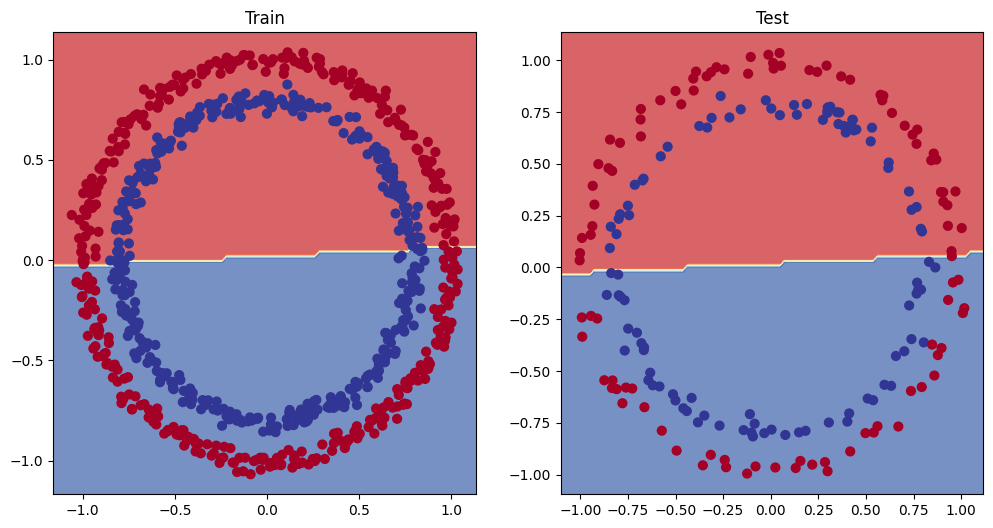

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Bingo, the problem is our model trying to split the red and blue dots using a straight line, since our data is circular, this straight line didn't capture the data pattern. That explains the 50% accuracy.
In machine learning, this kind of situation called underfitting, meaning the model is not learning predictive patterns from the data.

## 5. Improving a Model (From a Model Perspective)

In [22]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x): # note: always make sure forward is spelt correctly
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [24]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


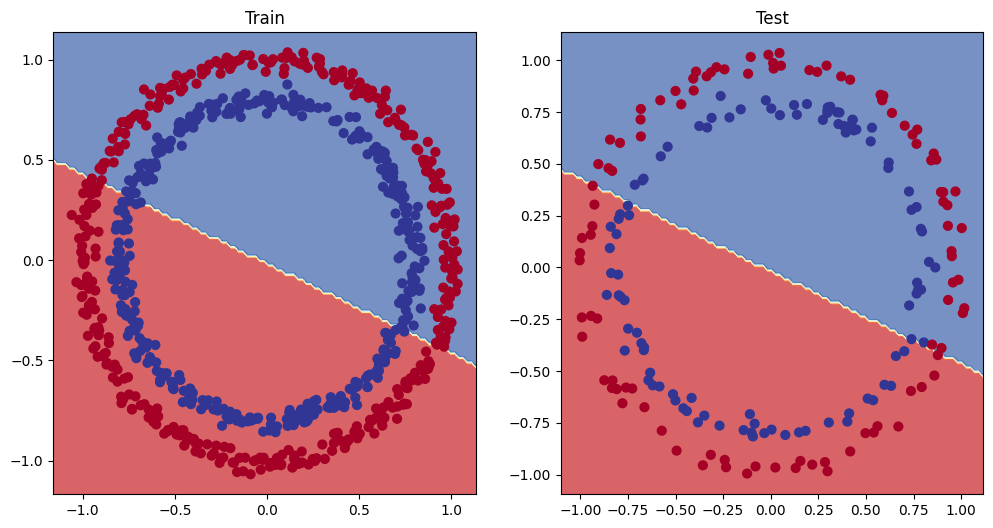

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)